This notebook explores the random phase initial conditions. It can also be used to generate random phase forcing.

In [83]:
import sys
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install scipy

import numpy as np
import time as tme
from numpy import *
from numpy import fft
from scipy import fftpack
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

Define transforms, grid and wavenumbers for Fourier-SinCos basis:

In [84]:
#
# FFT in X, SINE FFT in Z (sine transform)
#
def FFT_FST(N1,N2,F):
    F_hat = complex(0.,0.)*np.zeros((N1,N2))
    #
    #   Sine Transform first
    #
    for l in range(N1):
        F_hat[l,1:N2-1] = fftpack.dst(F[l,1:N2-1],type=1)/(np.float_(N2)-1.)
    #
    #  Then Fourier Transform
    #
    for q in range(N2):
        F_hat[:,q] = np.fft.fft(F_hat[:,q])
    #
    #  No normalization in this configuration
    #
    return F_hat

def iFFT_FST(N1,N2,F_hat):
    F = np.zeros((N1,N2))
    for k in range(N2):
        F[:,k] = np.fft.ifft(F_hat[:,k]).real
    #
    #   The F's are reals once we take the ifft, but they have complex parts that won't work
    #   with the sine transform, so we set them all real
    #
    #    F = real(F)

    #
    # Now that you have Reals take the inverse sine transform
    #
    for l in range(N1):
        F[l,1:N2-1] = fftpack.idst(F[l,1:N2-1],type=1)*.5
    #
    # Normalize for the inverse cosine transform
    #
    #    F = F/2./N2

    return F

In [85]:
Nx = 80
Nz = 180
#
# Here's the domain
#
Lx = 0.2
Lz = 0.45

#
# Here's the grid and the wave numbers
#

dx = float(Lx)/Nx
dz = float(Lz)/(Nz-1)

x = np.arange(Nx)*dx
z = np.arange(Nz)*dz
xv,zv = np.meshgrid(x,z)
#print(x)
#print(xv)

kkx       = np.fft.fftfreq(np.int_(Nx),Lx/Nx)*2.*np.pi
kkz       = np.arange(np.int_(Nz))*np.pi/Lz
#kkz       = np.fft.fftfreq(np.int_(Nz),Lz/Nz)*2.*np.pi
#print(kkx)
#print(kkz)

kkxv,kkzv = np.meshgrid(kkx,kkz)

print(max(kkx/2./np.pi*Lx))


39.0


Here we define the parameters to be used for the target shape of the potential energy spectra.

In [86]:
k_0  = 14                   # The wave number were the energy should be focused
m    = 25                   # A parmamter of the problem



In [87]:
print(k_0,m)

14 25


In [88]:
def BigPEK(kx, kz, k_0, m):
    """This is the type of function that is typically used to define amplitudes for random phase initial conditions
    
    ixw = the radius (ixw = sqrt(kx^2+kz^2))
    
    """
    ixw = np.sqrt(kx*kx + kz*kz)
    return ixw**(m/2.)/(ixw+k_0)**m

The following two cells define the arrays we will use for the buoyancy and its spectral coefficients.

In [89]:
rhoHat = np.zeros((np.int_(Nx),np.int_(Nz)), dtype='complex128')


In [90]:
rho = np.zeros((np.int_(Nx),np.int_(Nz)), dtype='complex128')


In [91]:
rho     = np.random.rand(Nx,Nz)     # Assign the density randomly
rhoHat = FFT_FST(Nx,Nz,rho)         # Compute its FFT to find the spectral coefficients -- which should be noisy
print(rho[4,4],rhoHat[4,4])

0.5132200195904375 (0.14054297849634537-0.009205802958872772j)


In [92]:
def PeCentroid(rhohat, kkx, kkz):
    """This function computes the 'centroid' of the potential energy. It is the wave number
       at which the PE is centered.
    """
    pe_top = 0
    pe_bot = 0
    ikx_count = 0
    for ikx in kkx:
        iikx = int(ikx/2./np.pi*Lx)
        ikz_count = 0
        for ikz in kkz:
            iikz = int(ikz/np.pi*Lz)
            xwj = np.sqrt(iikx*iikx + iikz*iikz)
            xw = np.sqrt(ikx*ikx + ikz*ikz)
            ixw = int(np.sqrt(iikx*iikx + iikz*iikz))
            pe_top = pe_top + xwj*rhohat[ikx_count, ikz_count]*rhohat[ikx_count, ikz_count].conj() 
            pe_bot = pe_bot + rhohat[ikx_count, ikz_count]*rhohat[ikx_count, ikz_count].conj()
            ikz_count += 1
        ikx_count += 1
    return pe_top.real/pe_bot.real


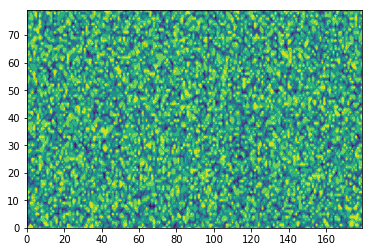

In [93]:
# This cell makes a contour plot of the real part of the density
plt.contourf(rho.real)
plt.show()

In [94]:
print('Centroid of original data is at wave number: ',PeCentroid(rhoHat, kkx, kkz))

Centroid of original data is at wave number:  25.011641452374622


Compute the PE energy in each wave number shell. The wave number of each shell is described by,

\begin{equation}
<k> = \sqrt{k_x^2+k_z^2},
\end{equation}
and can also be thought of as the radius of shells describing a circular or spherical wave number.


In [95]:
PEkshape = np.zeros((Nx,Nz), dtype = 'float')
ikx_count = 0
for ikx in kkx:
    ikz_count = 0
    for ikz in kkz:
        xw = sqrt(ikx*ikx/4./np.pi/np.pi*Lx*Lx + ikz*ikz/np.pi/np.pi*Lz*Lz)
        ixw = int(xw)
        energyValue = .5*xw*xw*rhoHat[ikx_count, ikz_count]*rhoHat[ikx_count, ikz_count].conj()
        PEkshape[ikx_count, ikz_count] = energyValue.real
        ikz_count += 1
    ikx_count += 1


0.31739320980386865


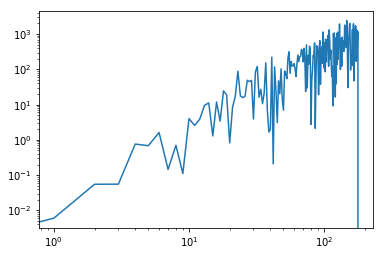

In [96]:

# Here we plot the potential energy as a function of the shell wave number. 
# We can see there is lots of noise  in the high wave numbers

print(PEkshape[4,4])
plt.loglog(PEkshape[1,:])
plt.show()

Below, renormalize the pe spectrum, so that it has a shape where the amplitudes (PE energy) have a shape that varies more slowly. This is the shape is also plotted up below.

In [97]:
BigPEkTarget = np.zeros(int(max(Nx,Nz)), dtype = 'float')
BigPEk = np.zeros(int(max(Nx,Nz)), dtype = 'float')
ixwSet = np.zeros(int(max(Nx,Nz)))
ikx_count = 0
for ikx in kkx:
    iikx = int(ikx/2./np.pi*Lx)
    ikz_count = 0
    for ikz in kkz:
        iikz = int(ikz/np.pi*Lz)
        xwj = np.sqrt(iikx*iikx + iikz*iikz)
        xw = np.sqrt(ikx*ikx + ikz*ikz)
        ixw = int(np.sqrt(iikx*iikx + iikz*iikz))
#        ixw = int(round(np.sqrt(iikx*iikx + iiky*iiky),0))
        ixwSet[ixw] += 1
        abspsiHat = rhoHat[ikx_count, ikz_count]*rhoHat[ikx_count, ikz_count].conj()
        BigPEk[ixw] = BigPEk[ixw] + .5*xw*xw*abspsiHat.real
        BigPEkTarget[ixw] = xwj**(m/2)/(xwj+k_0)**m
        ikz_count += 1
        #print(iikx, iikz, xwj, ixw)
    ikx_count += 1
#
# Renormalize BigETarget so that we see what the actual shape of potential energy is when it is
# binned according to the shell wave number, ix
#
BigPEkTarget = BigPEkTarget/max(BigPEkTarget)
BigPEk = BigPEk/max(BigPEk)
print(max(BigPEkTarget))
print(max(BigPEk))
#for i in range(Nx):
#    print (BigEk[i])

IndexError: index 180 is out of bounds for axis 0 with size 180

In [ ]:
plt.plot(ixwSet)
plt.xlim(0,Nx/2)
plt.title('This shows the ampitude of the NUMBER OF WAVE NUMBERs per shell')
plt.show()

In [ ]:
plt.plot(ixwSet)
plt.title('This is for the full range of wave numbers.')
plt.show()

In [ ]:
plt.loglog(BigPEk)
plt.title('This is the PE energy vs the shell wave number.')
plt.show()
plt.loglog(BigPEkTarget)
plt.title('This is the TARGET PE energy distribution')
plt.show()
BigRatio = BigPEkTarget/BigPEk
plt.plot(BigRatio)
plt.title('The ratio of the target over the actual vs wave number')
plt.show()

In the above figures, we can see that it is the low wave numbers that really need to be modified. Next! We renormalize the amplitudes of the original random initial condition so the amplitdues are slowly varrying.

So, renormalize.

* First loop over every wave number. Find out which 'shell' belong to each wave number and then divide the spectral coefficient by the max energy in that shell.
* Next multiply it by the target energy. 



In [ ]:
rhoHatNew = np.copy(rhoHat)
ikx_count = 0
for ikx in kkx:
    ikz_count = 0
    iikx = int(ikx/2./np.pi*Lx)
    for ikz in kkz:
        iikz = int(ikz/np.pi*Lz)
        xwj = np.sqrt(iikx*iikx + iikz*iikz)
        xw = np.sqrt(ikx*ikx + ikz*ikz)
        ixw = int(np.sqrt(iikx*iikx + iikz*iikz))
        if ixw > 0:
            rhoHatNew[ikx_count, ikz_count] = rhoHat[ikx_count,ikz_count]/BigPEk[ixw] 
            rhoHatNew[ikx_count, ikz_count] = rhoHatNew[ikx_count, ikz_count]*BigPEkTarget[ixw]
        else:
            rhoHatNew[ikx_count, ikz_count] = 0.
        ikz_count += 1
    ikx_count += 1
        

In [ ]:
print(rhoHatNew[0,14],rhoHat[0,14],BigPEk[14],BigPEkTarget[14])

Now that we have brand new, renormalized spectral coefficients, compute the new PEk! This should have a more smoothly varying shape.

In [ ]:
BigPEkNew = np.zeros(max(Nx,Nz), dtype = 'float')
ikx_count = 0
for ikx in kkx:
    iikx = int(ikx/2./np.pi*Lx)
    ikz_count = 0
    for iky in kkz:
        iikz = int(ikz/np.pi*Lz)
        xwj = np.sqrt(iikx*iikx + iikz*iikz)
        xw = np.sqrt(ikx*ikx + ikz*ikz)
        ixw = int(np.sqrt(iikx*iikx + iikz*iikz))
        absrhoHat = rhoHatNew[ikx_count, ikz_count]*rhoHatNew[ikx_count, ikz_count].conj()
        BigPEkNew[ixw] = BigPEkNew[ixw] + .5*xw*xw*absrhoHat.real
        ikz_count += 1
    ikx_count += 1


In [ ]:
plt.loglog(kkz/np.pi*Lz,BigPEkNew, 'b-') #note this may have empty space because we have made integers out of reals, above
plt.loglog(kkz/np.pi*Lz,BigPEk, 'y-')
plt.show()

In [ ]:
rhoNew = iFFT_FST(Nx,Nz,rhoHatNew) # Go back to physical space, and we should see some larger scale structure

In [ ]:
plt.contourf(rhoNew.real) # Should look smoother
plt.show()

Copmute the ke centroid

In [ ]:
print('PeCentroid New is: ',PeCentroid(rhoHatNew, kkx, kkz))  # The centroid should be at a lower wave number.